# This notebook perform the spectral analysis of a pressure sensor in the Bay of Waimea (Hawaii)
##### g.marechal (Golden, October 2023)

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

import xarray as xr

from scipy.signal import welch

import datetime
import time


from scipy.io import loadmat
from pressure_sensor_fct import *

In [2]:
path_pressure = '/Users/gwen29360/Desktop/POSTDOC/Mines/COURS/Physical_Oceanography/Waves/DATA/pressure_waimea.nc' #edit here the path


In [3]:
##########
# --- Load the pressure data
##########
ds_pressure = xr.open_dataset(path_pressure)  
nt = 43180//4 # length of record

##########
# --- Load buoy data at the same time
##########
ds_cdip = xr.open_dataset('http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/106p1/106p1_historic.nc?waveTime[0:1:343730],waveHs[0:1:343730]')
sub_cdip = ds_cdip.sel(waveTime = ds_pressure.time[nt].values, method = 'nearest') # Select the corresponding time

##### TODO_1: Plot the first 400_000 points of the signal. Can you describe the dominant frequency of this signal? What can lead to this modulation? You can verify you assumption on Internet: Waimea bay ???? forecast noaa (replace ???? with the name of the signal you assumed.)

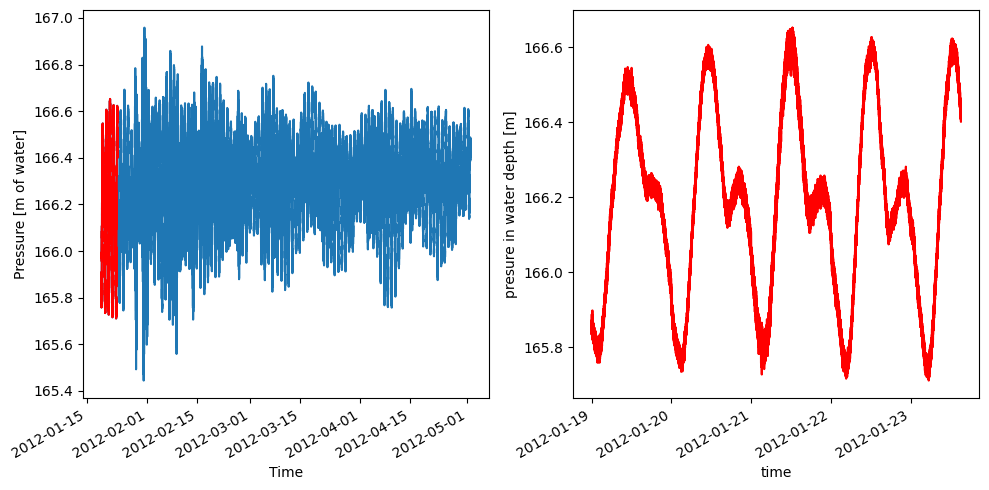

In [4]:
# TODO_1:
fig, axes= plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
ax = axes[0]
ds_pressure.pressure.plot(ax = ax)
ds_pressure.pressure[0:400_000].plot(ax = ax, color = 'r')

ax.set_xlabel('Time')
ax.set_ylabel('Pressure [m of water]')
ax = axes[1]
ds_pressure.pressure[0:400_000].plot(ax = ax, color = 'r')
plt.tight_layout()

# Spectral analysis

Text(0, 0.5, 'Pressure spectrum [$dbar^{2}/Hz$]')

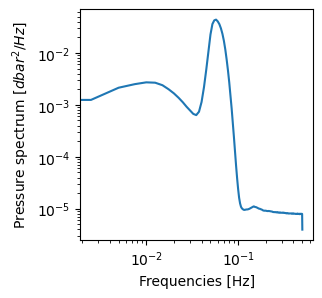

In [5]:
nfft = 400 # the number of point for the spectral analysis

########
# ---  The scipy.signal welch function perform exactly the function you used in the first practical
########
freq, psd = welch(ds_pressure.pressure, fs = 1, window='hanning', nperseg=nfft, detrend='linear', return_onesided=True, scaling='density')

fig, ax = plt.subplots(figsize = (3,3))
ax.loglog(freq, psd)
ax.set_xlabel('Frequencies [Hz]')
ax.set_ylabel('Pressure spectrum [$dbar^{2}/Hz$]')

##### TODO_2: Compare the significant wave height from the Buoy (at the surface) and the pressure sensor (used the formula of TODO_3 of tutorial_swell.ipynb). Can you guess why the two results are so different?

In [6]:
### TODO_2: 

hs_pressure = 0.00001
print(f'The Significant wave height measured by the pressure sensor is {hs_pressure} m')
print(f'The Significant wave height measured by the buoy at the surface is {sub_cdip.waveHs.values} m')


The Significant wave height measured by the pressure sensor is 1e-05 m
The Significant wave height measured by the buoy at the surface is 1.409999966621399 m


### Switch nfft to a larger number (e.g 431800) and spot where are the peaks of energy

##### TODO_3: From the tutorial_swell prectical, what is band of frequency associated to the surface waves, can you guess some of the others harmonics visible?

In [7]:
nfft = 43180 * 10 # the number of point for the spectral analysis

freq, psd = welch(ds_pressure.pressure, fs = 1, window='hanning', nperseg=nfft, detrend=None, return_onesided=True, scaling='density')

Text(0, 0.5, 'Pressure spectrum [$dbar^{2}/Hz$]')

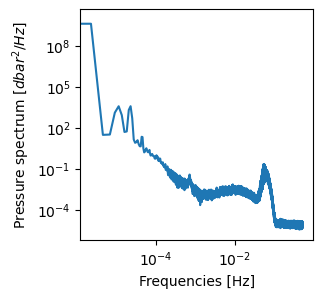

In [8]:
# TODO_3:
fig, ax = plt.subplots(figsize = (3,3))
ax.loglog(freq, psd)
ax.set_xlabel('Frequencies [Hz]')
ax.set_ylabel('Pressure spectrum [$dbar^{2}/Hz$]')

### Convert the pressure spectrum into an elevation spectrum

In [9]:
nfft = 400
nt = 43180//4 # length of record

freq, psd = welch(ds_pressure.pressure[:nt], fs = 1, window='hanning', nperseg=nfft, detrend='linear', return_onesided=True, scaling='density')

### Apply the transfert function

In [10]:
dep = ds_pressure.pressure.mean()
print(f'Mean depth is {dep.values} m')
wavenumber = dispNewtonTH(freq, dep.values) # get the wavenumber
Ef = ep_to_ef(psd, dep.values, wavenumber, nfft) # This is the elevation spectrum


Mean depth is 166.28666098995657 m


/Users/gwen29360/Desktop/POSTDOC/Mines/S_MODE/python/WAVES/BUOY/pressure_sensor_fct.py:35: RuntimeWarning: invalid value encountered in true_divide
  X=X-F/FD


##### TODO_4: can you estimate the new significant wave height from Ef and compare it with the measurement at the surface

In [11]:
# TODO_4:
hs_pressure = 0.0001
print(f'The Significant wave height measured by the pressure sensor is {hs_pressure} m') # Same formula as TODO_3 of the first practical
print(f'The Significant wave height measured by the buoy at the surface is {sub_cdip.waveHs.values} m')


The Significant wave height measured by the pressure sensor is 0.0001 m
The Significant wave height measured by the buoy at the surface is 1.409999966621399 m


### How the wave spectrum evolves along the 100 days of measurement?

In [12]:
nrec = 208 # Number of records
recfac = 4 # Number of spectra per pressure record (in 12h)
ntr = 3600*3       # seconds in 3 hours

nfft = 400
fs = 1
nt = 43180


Ef_all, time_4_spec = compute_periodogram(ds_pressure, nrec, recfac, ntr, nt, nfft, fs)

### Plot Periodogram

Text(0, 0.5, 'Frequencies [Hz]')

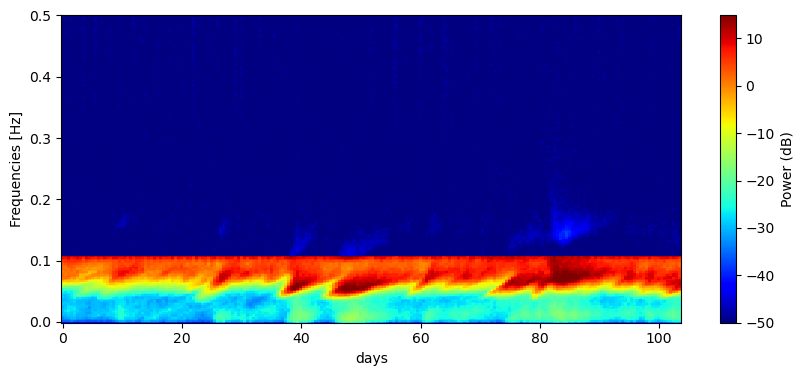

In [13]:
time_start = time_4_spec[0] # first date
time_numeric = [date2num(dt) - date2num(time_start) for dt in time_4_spec] # get numeric date for the plot

TIME, FREQ = np.meshgrid(time_numeric, freq)

fig, ax = plt.subplots(figsize = (10, 4))
im = ax.pcolor(TIME, FREQ, 10*np.log10(Ef_all), vmin = -50, vmax = 15, cmap = 'jet')

# You can customize the colorbar, labels, and other plot settings as needed
plt.colorbar(im, label='Power (dB)')
ax.set_xlabel('days')
ax.set_ylabel('Frequencies [Hz]')


##### TODO_5: The periodogram show you how the wave spectrum inferred from the pressure measurements evolves along time. Can you describe:
- The three main frequency bands where you can see a peak of energy. Can you associated them to the geophysical processes? (BONUS)
- Why there is a drop of energy at freq > 0.11 Hz
- Look how the dominant frequency evolve during a storm (use code below). How the dominant wave frequency evolve in time? Compute the associated group velocity ($\frac{1}{2}\frac{g}{2\pi freq}$) and describe the dispersion of the waves in deep water.

Text(0, 0.5, 'Energy spectrum [$m^{2}/Hz$]')

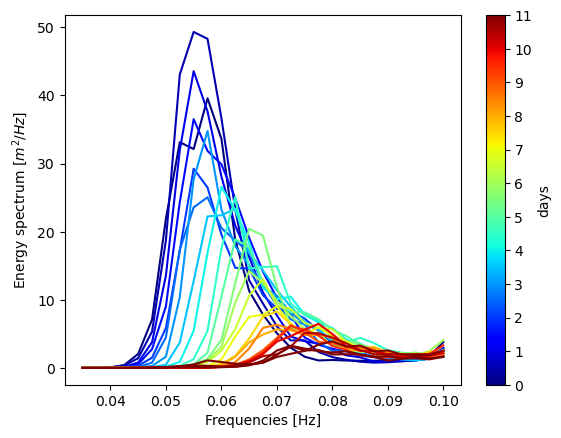

In [14]:
time_hours = np.arange(0, 12, 1)
sub_Ef_all = Ef_all[14:-160, 95:120] # The first dimension are the frequencies and the second dimension the time
# dt = 12 h


n_lines = np.size(sub_Ef_all, axis = 1)/2


cmap = plt.cm.get_cmap('jet', n_lines)


#sub_TIME, sub_FREQ = np.meshgrid(time_numeric[90:120], freq[:-170])
#cmap = cm.get_cmap('jet')
norm = mpl.colors.Normalize(vmin=time_hours.min(), vmax =time_hours.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])


fig, ax = plt.subplots()
for i in range(np.size(sub_Ef_all, axis = 1)):

    line, = ax.plot(freq[14:-160], sub_Ef_all[:, i], c=cmap.to_rgba(i/2))
    
    
#plt.legend(ncol = 3)
cbar = fig.colorbar(cmap, ticks = time_hours)
cbar.ax.set_ylabel('days')
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Energy spectrum [$m^{2}/Hz$]')
